# MPI calibration: comparison between the classical calibration and the ring experiment

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.BaseLoader)

def load_ringrong(zip_name):
    df = read_csv(zip_name, 'result.csv').reset_index()
    df['msg_size'] = df['size']
    df.drop('size', inplace=True, axis=1)
    df['sub_id'] = df['index'] // 2 # identifying the MPI_Send and MPI_Recv that are part of a same ping-pong
    df['op_kind'] = df['sub_id'] % 2 # each rank makes two distincts ping-pong: one recv-send with the previous rank and one send-recv with the next rank
    df.loc[df['op_kind'] == 0, 'op_kind'] = 'recv-send'
    df.loc[df['op_kind'] == 1, 'op_kind'] = 'send-recv'
    remote_next = {31, 63}
    remote_prev = {0, 32}
    df.loc[df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'loopback'
    df.loc[df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'loopback'
    df_send = df[df['function'] == 'MPI_Send']
    df_recv = df[df['function'] == 'MPI_Recv']
    df_ringrong = df_send.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']).join(df_recv.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']), lsuffix='_send', rsuffix='_recv').reset_index()
    df_ringrong['duration'] = df_ringrong['duration_send'] + df_ringrong['duration_recv']
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    for df in [df_send, df_recv, df_ringrong]:
        df['cluster'] = info['cluster']
        for key in ['matrix_size', 'perf_pct']:
            df[key] = int(install[key])
        for key in ['hyperthreading', 'turboboost', 'idle_state']:
            df[key] = install[key]
    return {
        'ringrong': df_ringrong,
        'send': df_send,
        'recv': df_recv
    }

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def load_classical(zip_name):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    nb_nodes = len(get_yaml(zip_name, 'oarstat.yaml')['assigned_network_address'])
    if nb_nodes == 1:
        experiment = 'loopback'
    elif nb_nodes == 2:
        experiment = 'remote'
    else:
        assert False
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'recv'  : pingpong_recv,
    }
    for df in result.values():
        df['experiment'] = experiment
    return result

In [2]:
directory = '250MB/ring/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
df_ringrong = pandas.concat([load_ringrong(f)['recv'] for f in archives])
df_ringrong = df_ringrong[(df_ringrong['op_kind'] == 'recv-send') & (df_ringrong['rank'] != 0)]
df_ringrong['kind'] = 'ringrong'
df_ringrong

,index,function,rank,op_id,timestamp,duration,msg_size,sub_id,op_kind,experiment,cluster,matrix_size,perf_pct,hyperthreading,turboboost,idle_state,kind
400,400,MPI_Recv,10,0,1.185648,0.073001,268435456,200,recv-send,loopback,dahu,0,100,false,true,false,ringrong
404,404,MPI_Recv,10,1,10.096957,0.064184,268435456,202,recv-send,loopback,dahu,0,100,false,true,false,ringrong
408,408,MPI_Recv,10,2,19.062844,0.073161,268435456,204,recv-send,loopback,dahu,0,100,false,true,false,ringrong
412,412,MPI_Recv,10,3,28.226375,0.073145,268435456,206,recv-send,loopback,dahu,0,100,false,true,false,ringrong
416,416,MPI_Recv,10,4,37.374775,0.072962,268435456,208,recv-send,loopback,dahu,0,100,false,true,false,ringrong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25580,25580,MPI_Recv,63,95,1304.434060,0.149291,268435456,12790,recv-send,loopback,dahu,128,100,false,true,false,ringrong
25584,25584,MPI_Recv,63,96,1317.959521,0.152459,268435456,12792,recv-send,loopback,dahu,128,100,false,true,false,ringrong
25588,25588,MPI_Recv,63,97,1331.503782,0.151617,268435456,12794,recv-send,loopback,dahu,128,100,false,true,false,ringrong
25592,25592,MPI_Recv,63,98,1345.149075,0.152126,268435456,12796,recv-send,loopback,dahu,128,100,false,true,false,ringrong


In [3]:
directory = '250MB/classical/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
df_classical = pandas.concat([load_classical(f)['recv'] for f in archives])
df_classical['kind'] = 'classical'
df_classical

,op,msg_size,start,duration,experiment,type,deployment,index,kind
0,MPI_Recv,268435456,0.000002,0.131057,loopback,exp/exp_PingPong.csv,debian9-x64-base,1,classical
1,MPI_Recv,268435456,0.257119,0.058221,loopback,exp/exp_PingPong.csv,debian9-x64-base,3,classical
2,MPI_Recv,268435456,0.370865,0.058118,loopback,exp/exp_PingPong.csv,debian9-x64-base,5,classical
3,MPI_Recv,268435456,0.484309,0.057962,loopback,exp/exp_PingPong.csv,debian9-x64-base,7,classical
4,MPI_Recv,268435456,0.597458,0.057966,loopback,exp/exp_PingPong.csv,debian9-x64-base,9,classical
...,...,...,...,...,...,...,...,...,...
95,MPI_Recv,268435456,4.279998,0.021944,remote,exp/exp_PingPong.csv,debian9-x64-base,191,classical
96,MPI_Recv,268435456,4.323658,0.021972,remote,exp/exp_PingPong.csv,debian9-x64-base,193,classical
97,MPI_Recv,268435456,4.367321,0.021957,remote,exp/exp_PingPong.csv,debian9-x64-base,195,classical
98,MPI_Recv,268435456,4.410996,0.021933,remote,exp/exp_PingPong.csv,debian9-x64-base,197,classical


MPI_Recv


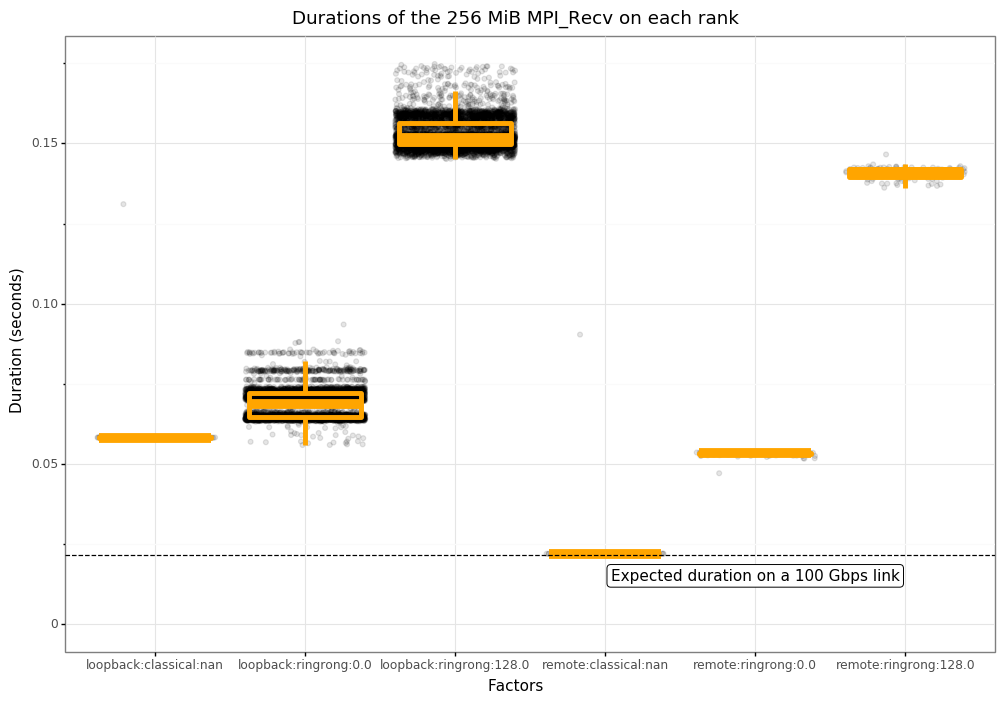

<ggplot: (-9223363276195136957)>

In [4]:
bw  = 12.5*1e9
lat = 0.1*1e-6

tmp = pandas.concat([df_ringrong, df_classical])
tmp['x'] = tmp['experiment'] + ':' + tmp['kind'] + ':' + tmp['matrix_size'].astype(str)

size = tmp['msg_size'].max()
theoretical_duration = size/(bw) + lat

function = df_ringrong['function'].unique()
assert len(function) == 1
function = function[0]
print(function)

(ggplot(tmp)
    + aes(x='x', y='duration')
    + geom_jitter(alpha=0.1) 
    + geom_boxplot(outlier_alpha=0, alpha=0, color='orange', size=2)
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + labs(x='Factors', y='Duration (seconds)')
    + annotate('label', x=5, y=theoretical_duration*0.7, label='Expected duration on a 100 Gbps link')
    + ggtitle(f'Durations of the {size/(2**20):.0f} MiB {function} on each rank')
)